In [1]:
import subprocess
import sys
import time
import os

def lsAdameyko(path="/home/sergey/data/clonal_project/cellranger"):
    samples = subprocess.check_output(
        f'ssh -t sergey@adameykolab.srv.meduniwien.ac.at "ls {path}"', shell=True
    ).decode(sys.stdout.encoding).strip().split("\n")
    return samples

In [3]:
import scanpy as sc
import numpy as np
import muon as mu
import scanpy.external as sce
import pandas as pd
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/home/sergey/data/clonal_project"
HOME_PATH = "/home/sergey/projects/clonal_project"

# Additional functions
exec(open(f"{HOME_PATH}/tools/tools.py").read())
sns.set_style("ticks")

In [4]:
def log1pPF(adata):
    adata_tmp = adata.copy()
    adata_tmp.layers["counts"] = adata_tmp.X.copy()
    sc.pp.normalize_total(adata_tmp)
    sc.pp.log1p(adata_tmp)
    sc.pp.highly_variable_genes(adata_tmp, n_top_genes=3000)
    adata_tmp.layers["scaled"] = sc.pp.scale(adata_tmp.X, max_value=10, copy=True)
    adata_tmp.obsm["X_pca"] = sc.pp.pca(adata_tmp[:, adata_tmp.var.highly_variable].layers["scaled"])
    sc.pp.neighbors(adata_tmp, n_pcs=30, n_neighbors=20)
    sc.tl.umap(adata_tmp)
    sc.tl.leiden(adata_tmp)
    
    return adata_tmp

In [6]:
description = {
    "sample_id" : "10x91",
    "batch" : "injection5",
    "FPs" : ["GFPbc", "TOMbc"],
    "plasmids" : ["pmr532", "pmr671"],
    "location" : "trunk",
    "devtime" : "E13.5",
    "injections" : ["E7.5", "E8.5"],
    "CRISPR": False,
}

## % mt is not a key

In [42]:
sample = description["sample_id"]
adata_filtered = sc.read_10x_h5(f"{DATA_PATH}/cellranger/{sample}/{sample}_GEX_filtered_feature_bc_matrix.h5")
adata_raw = sc.read_10x_h5(f"{DATA_PATH}/cellranger/{sample}/{sample}_GEX_raw_feature_bc_matrix.h5")
sc.pp.filter_cells(adata_raw, min_counts=100)

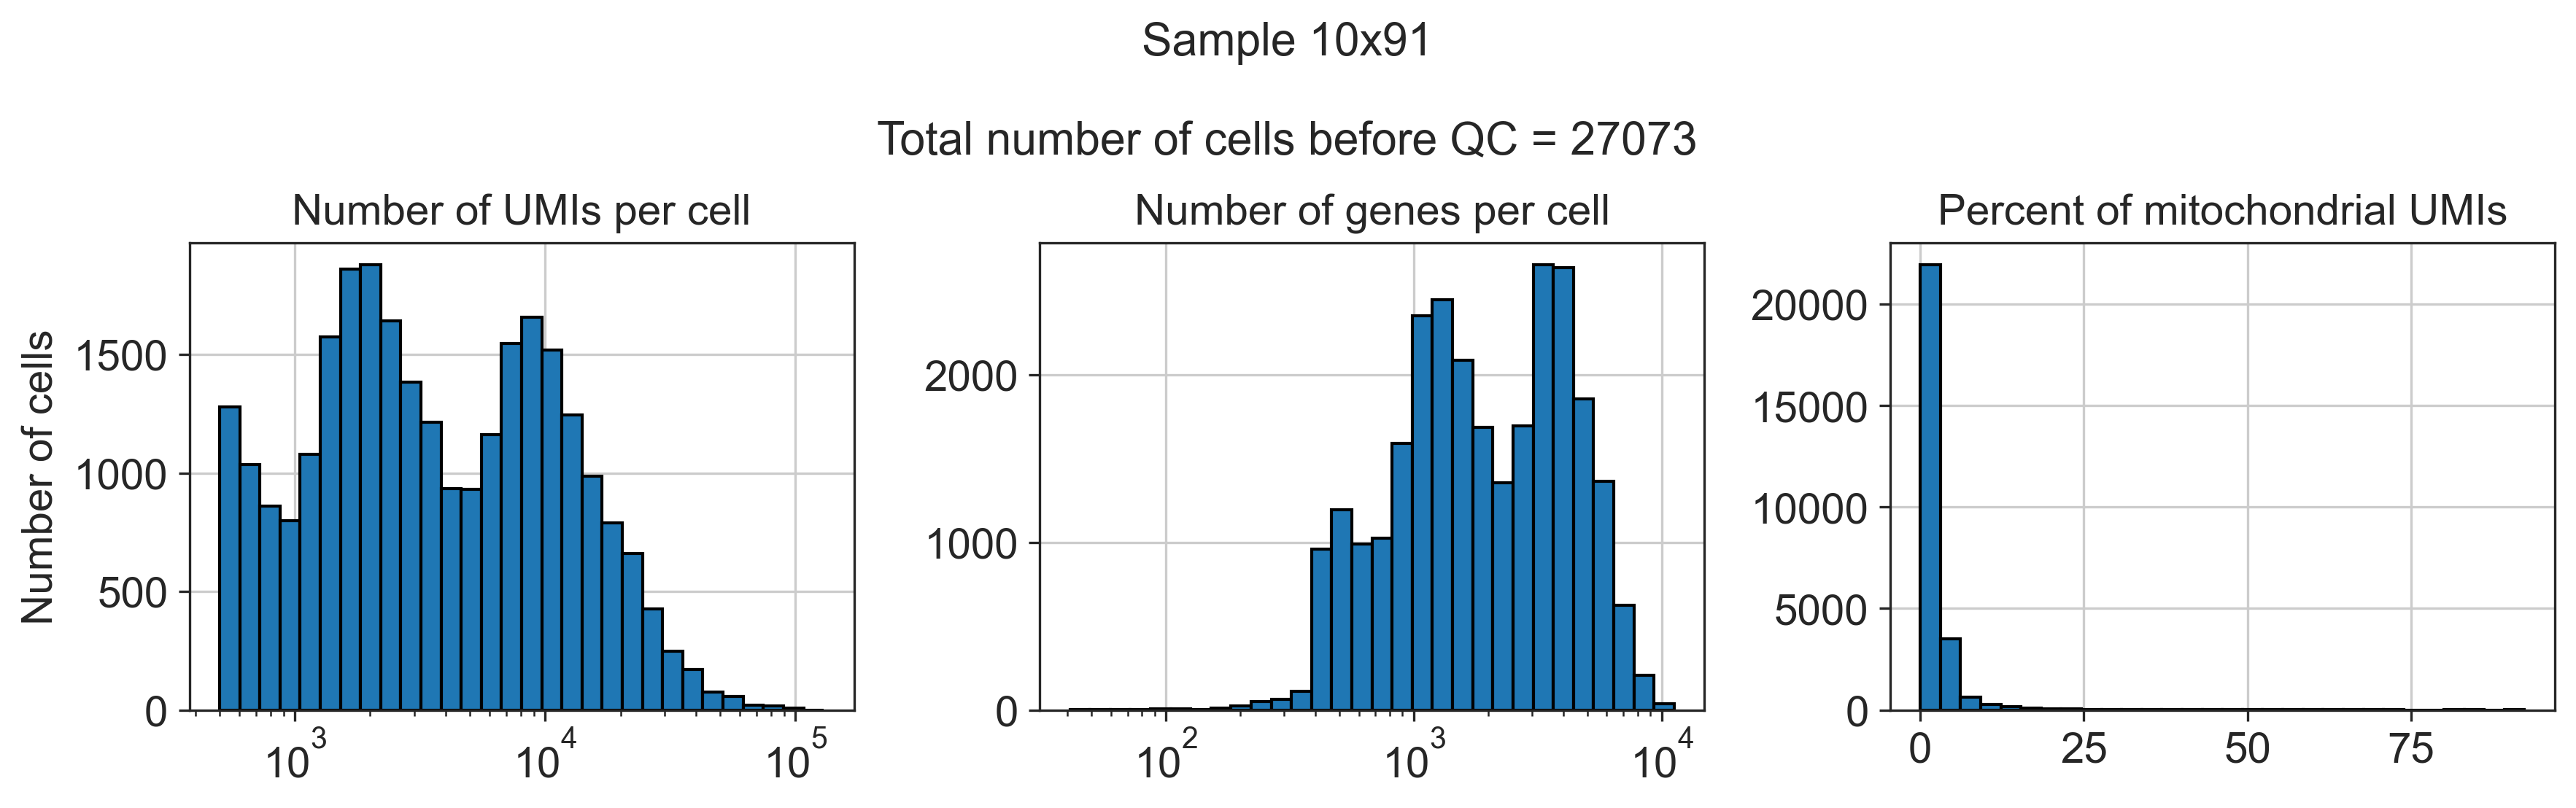

In [44]:
adata_filtered.var["mt"] = adata_filtered.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_filtered, inplace=True, percent_top=None, log1p=False, qc_vars=["mt"])
qc_plot = draw_counts_qc(adata_filtered, title=f"Sample {description['sample_id']}\n\nTotal number of cells before QC = {len(adata_filtered)}")

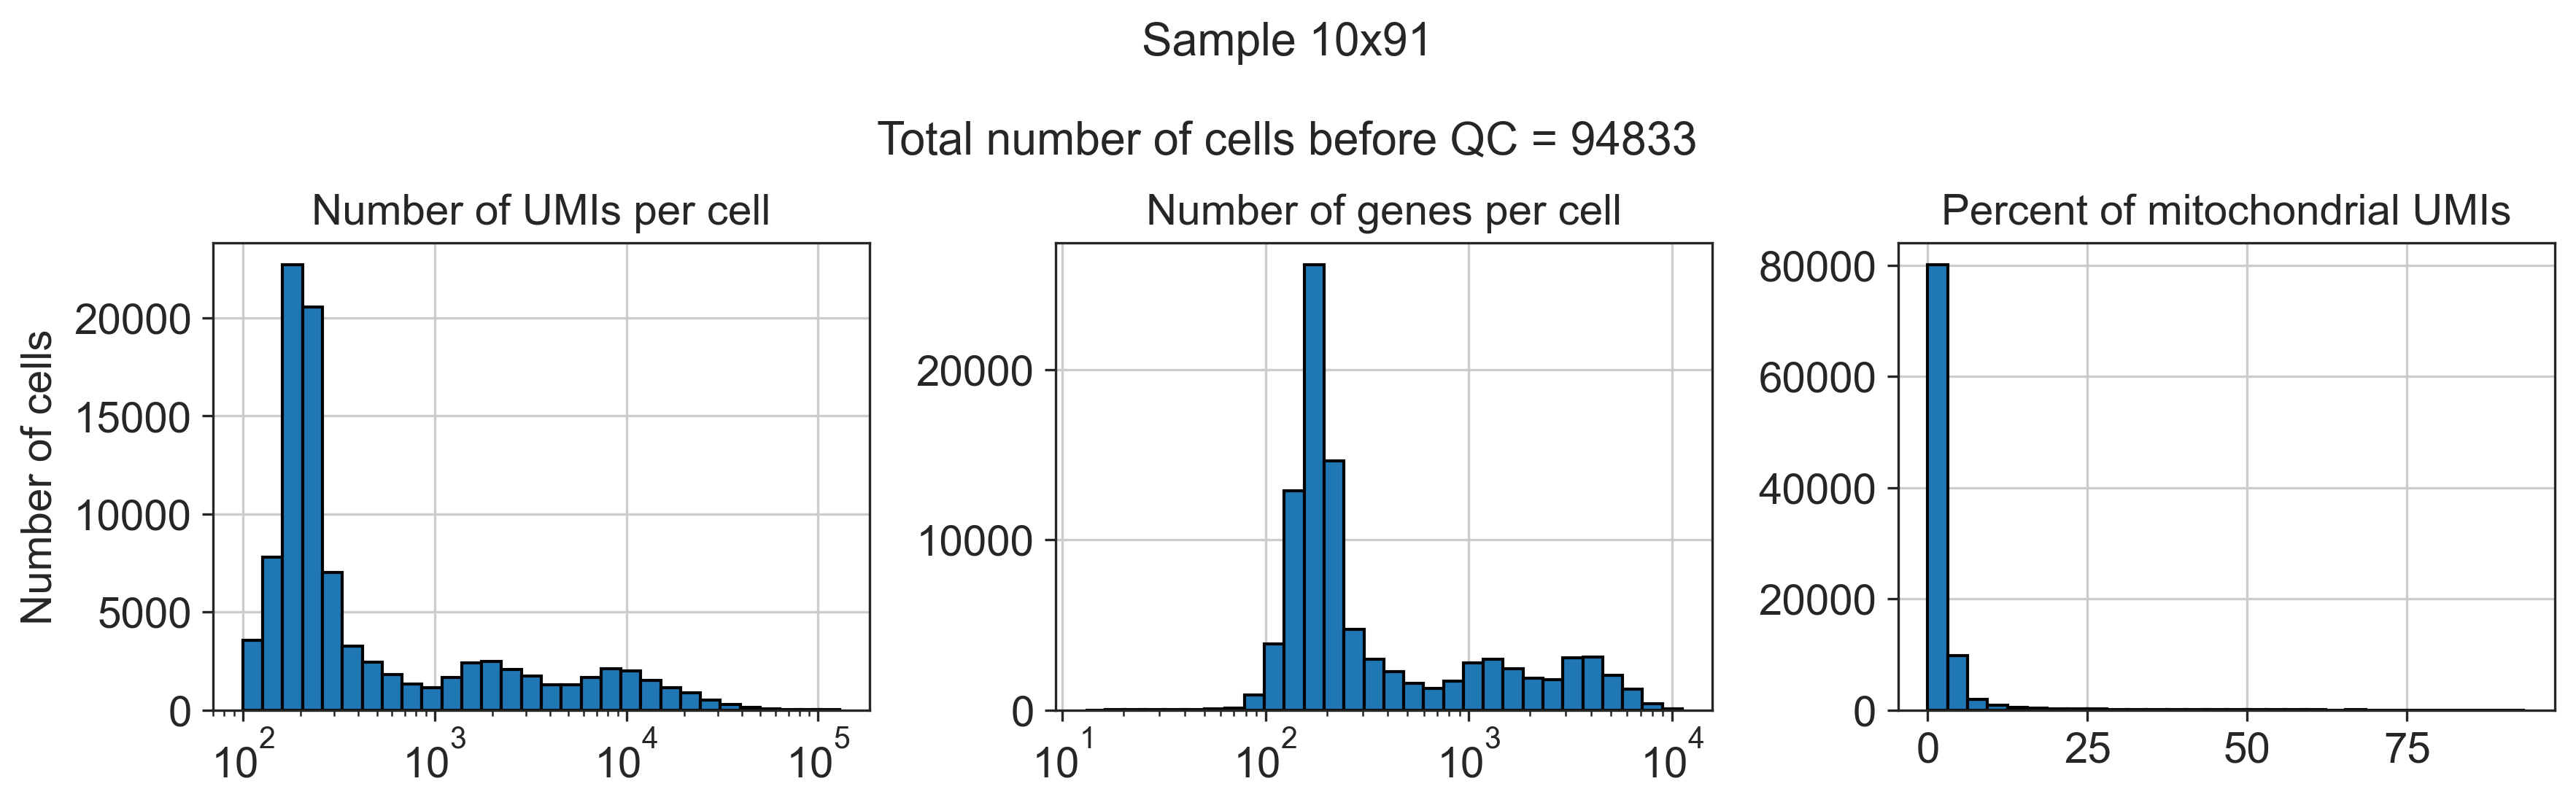

In [12]:
adata_raw.var["mt"] = adata_raw.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_raw, inplace=True, percent_top=None, log1p=False, qc_vars=["mt"])
qc_plot = draw_counts_qc(adata_raw, title=f"Sample {description['sample_id']}\n\nTotal number of cells before QC = {len(adata_raw)}")

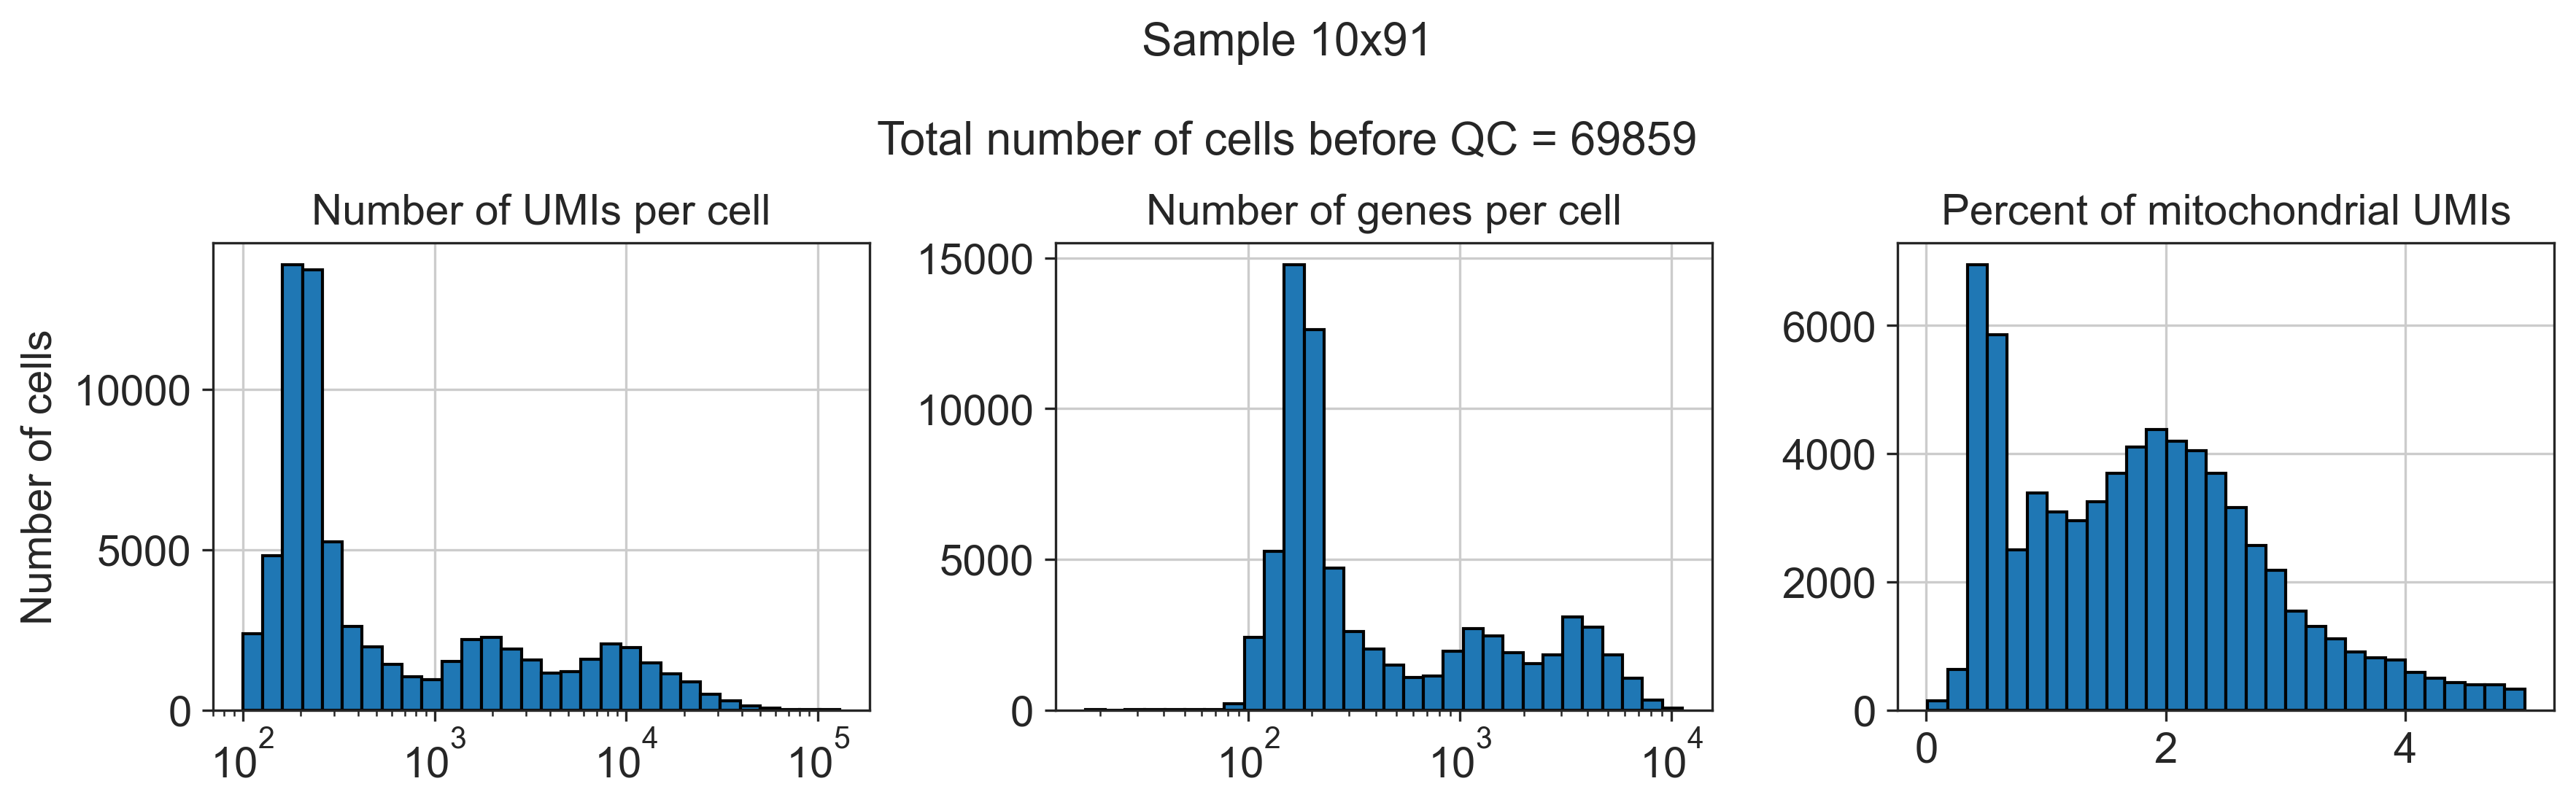

In [17]:
adata_raw = adata_raw[adata_raw.obs.pct_counts_mt < 5]
adata_raw = adata_raw[adata_raw.obs.pct_counts_mt > 0]
qc_plot = draw_counts_qc(adata_raw, title=f"Sample {description['sample_id']}\n\nTotal number of cells before QC = {len(adata_raw)}")

## Differences

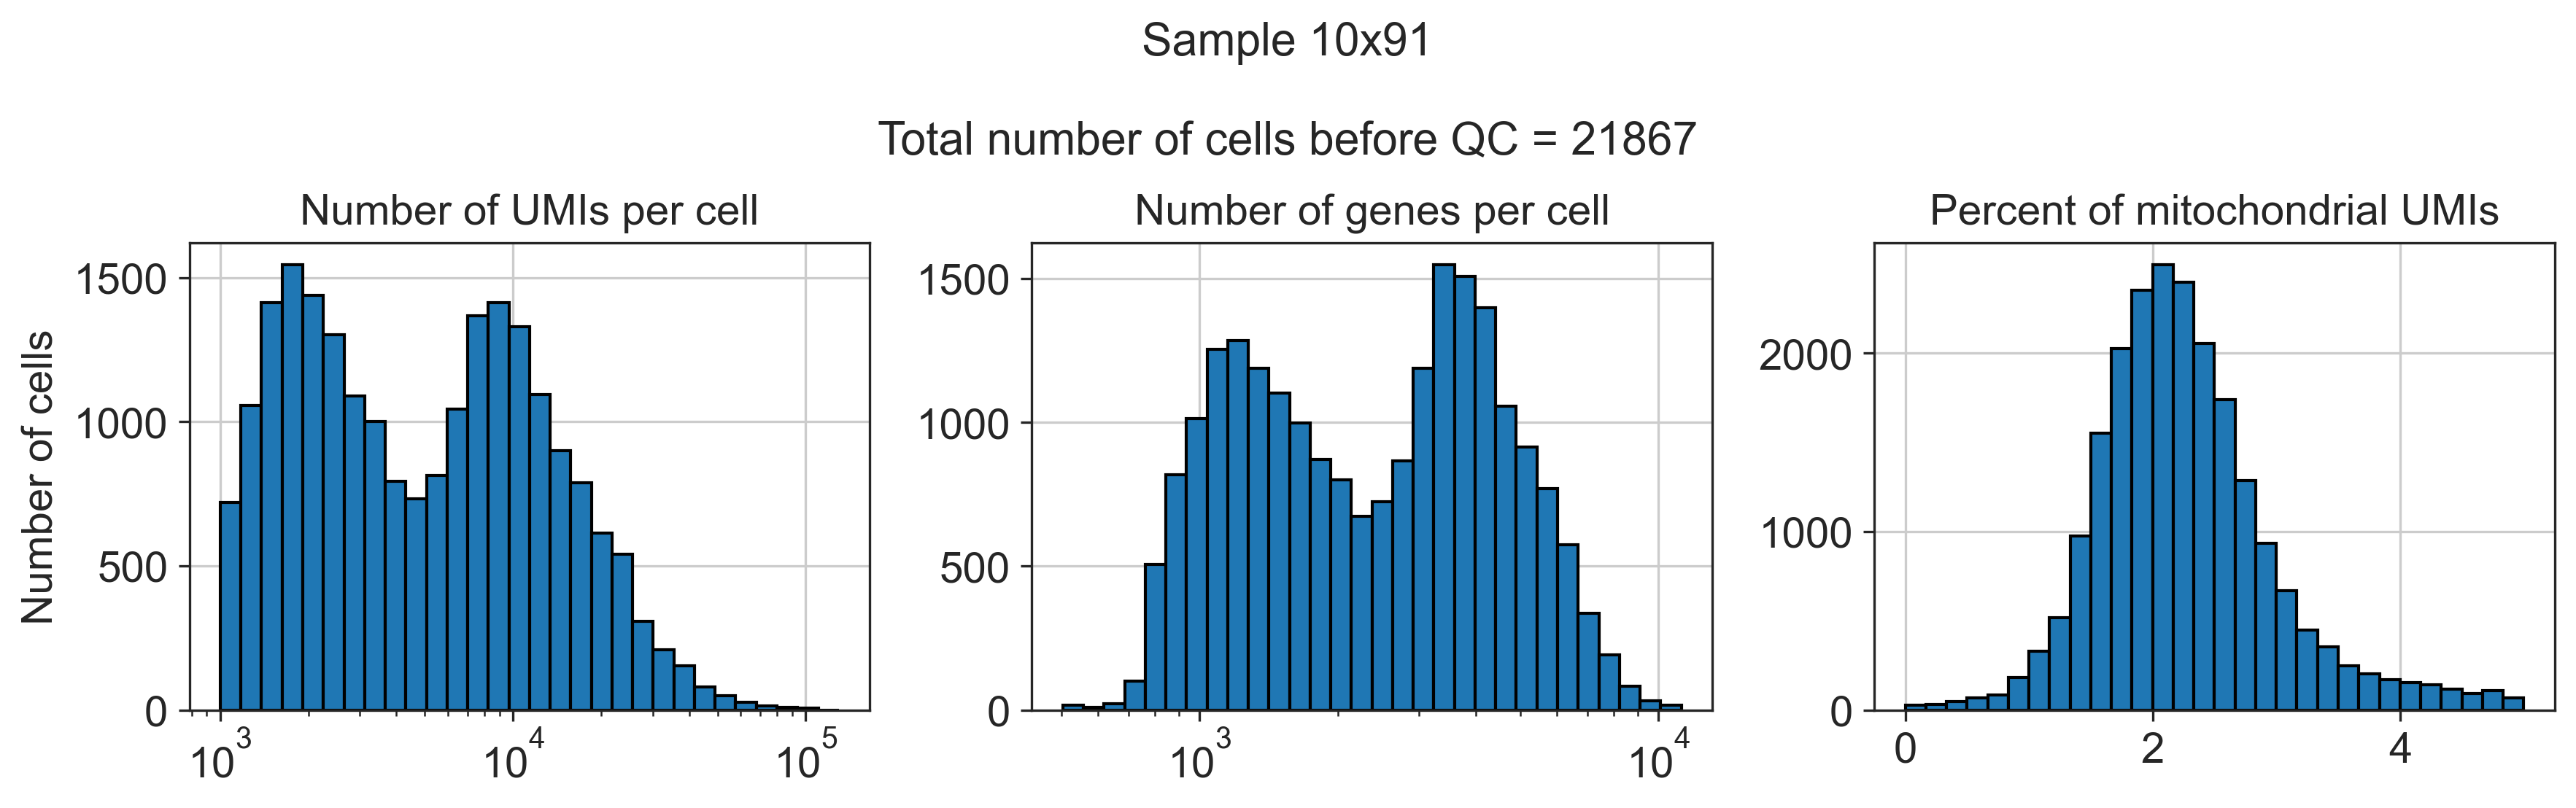

In [45]:
adata_filtered = adata_filtered[adata_filtered.obs.total_counts > 1000]
adata_filtered = adata_filtered[adata_filtered.obs.pct_counts_mt < 5]
adata_filtered = adata_filtered[adata_filtered.obs.n_genes_by_counts > 500]

qc_plot = draw_counts_qc(adata_filtered, title=f"Sample {description['sample_id']}\n\nTotal number of cells before QC = {len(adata_filtered)}")

In [46]:
adata_filtered.var["ribo"] = adata_filtered.var_names.str.startswith(("Rps", "Rpl"))
sc.pp.calculate_qc_metrics(adata_filtered, inplace=True, percent_top=None, log1p=False, qc_vars=["mt", "ribo"])

In [47]:
adata = adata_filtered.copy()
adata.obs.index = [sample + ":" + bc.split("-")[0] for bc in adata.obs.index]

In [49]:
from scipy.sparse import vstack, hstack, csr_matrix

adatas_FP = {}
for FP in description["FPs"]:
    adatas_FP[FP] = sc.read_h5ad(f"{DATA_PATH}/trex/{sample}/{FP}.h5ad")
    adatas_FP[FP].obs.index = [sample + ":" + bc for bc in adatas_FP[FP].obs.index]
    adatas_FP[FP] = adatas_FP[FP][np.isin(adatas_FP[FP].obs_names, adata.obs_names)]
    empty_cells = adata.obs_names[~np.isin(adata.obs_names, adatas_FP[FP].obs_names)]
    adatas_FP[FP] = sc.AnnData(
        X=vstack([adatas_FP[FP].X, csr_matrix(np.zeros((len(empty_cells), len(adatas_FP[FP].var_names))))]),
        obs=pd.DataFrame(index=(list(adatas_FP[FP].obs_names) + list(empty_cells))),
        var=adatas_FP[FP].var
    )
    adatas_FP[FP] = adatas_FP[FP][adata.obs_names]
    adatas_FP[FP].X[(adatas_FP[FP].X <= 1).A] = 0
    adatas_FP[FP] = adatas_FP[FP][:, adatas_FP[FP].X.sum(axis=0).A[0] > 0]

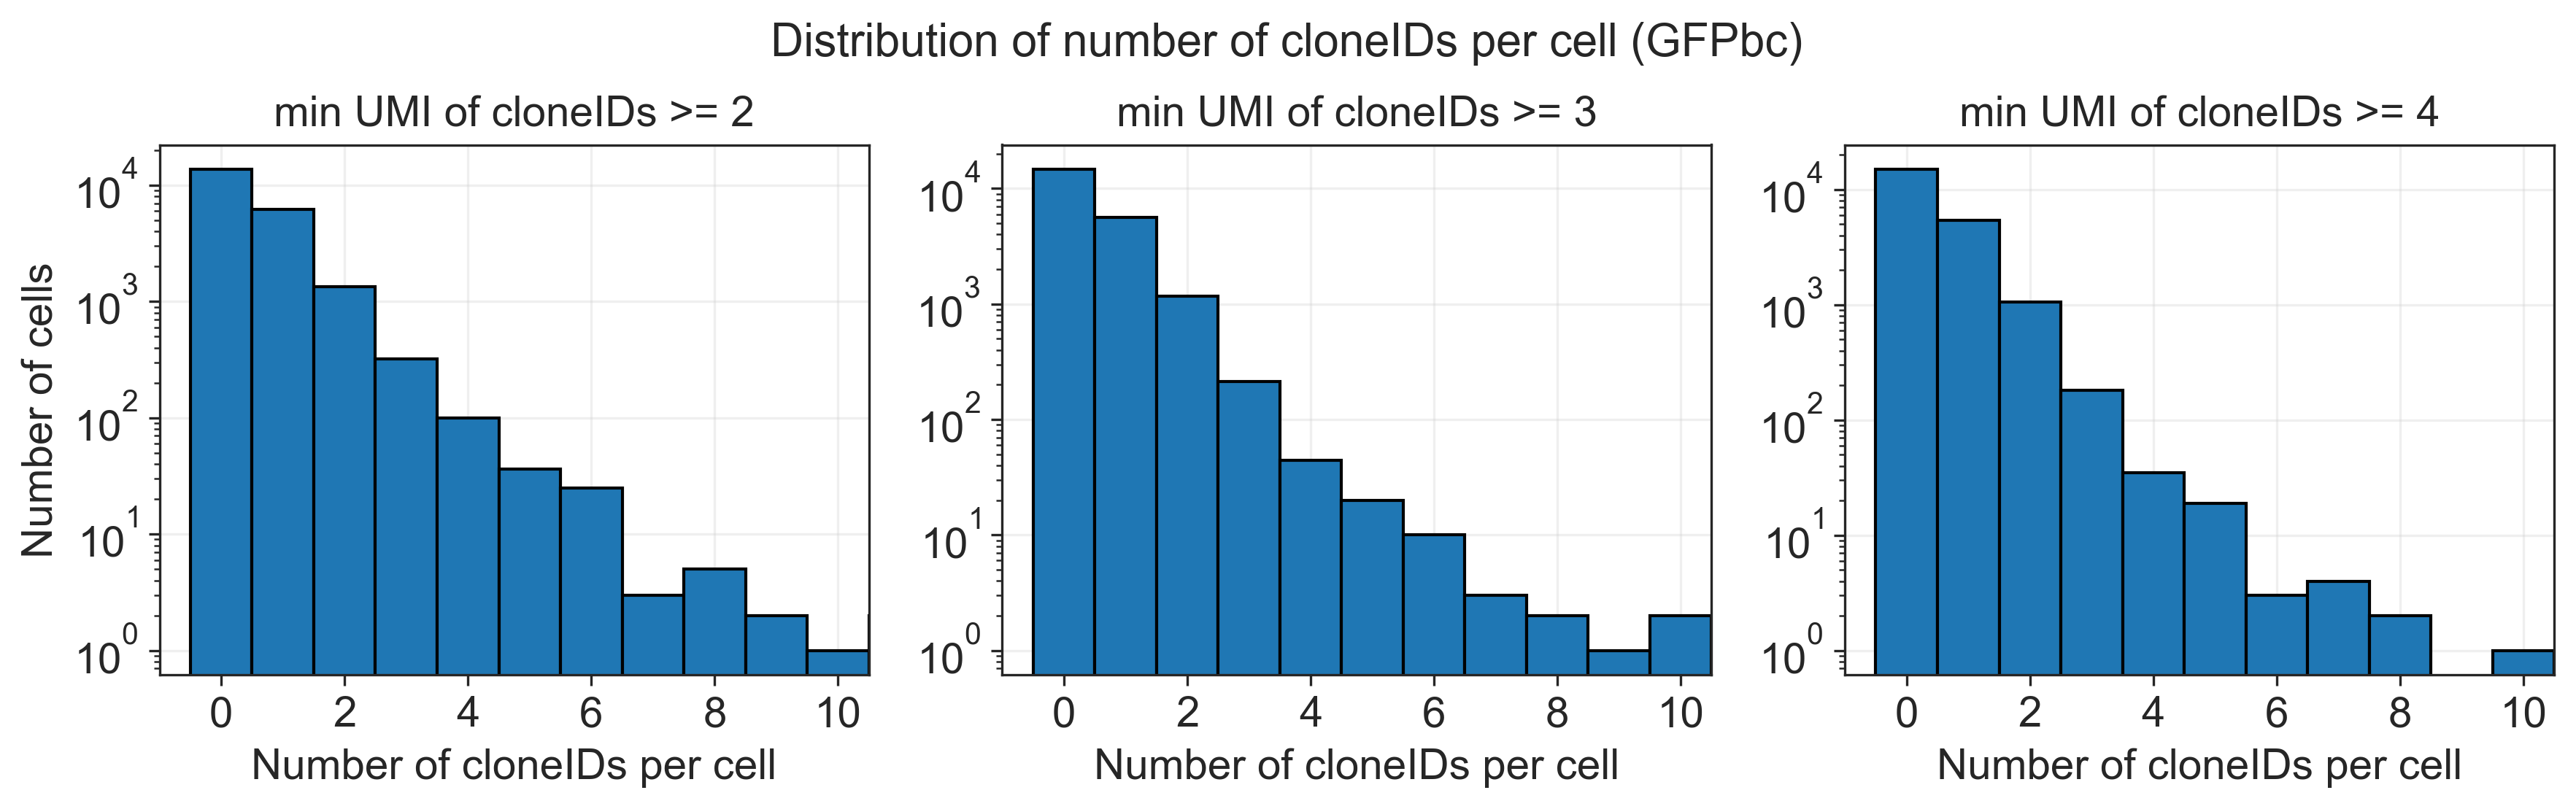

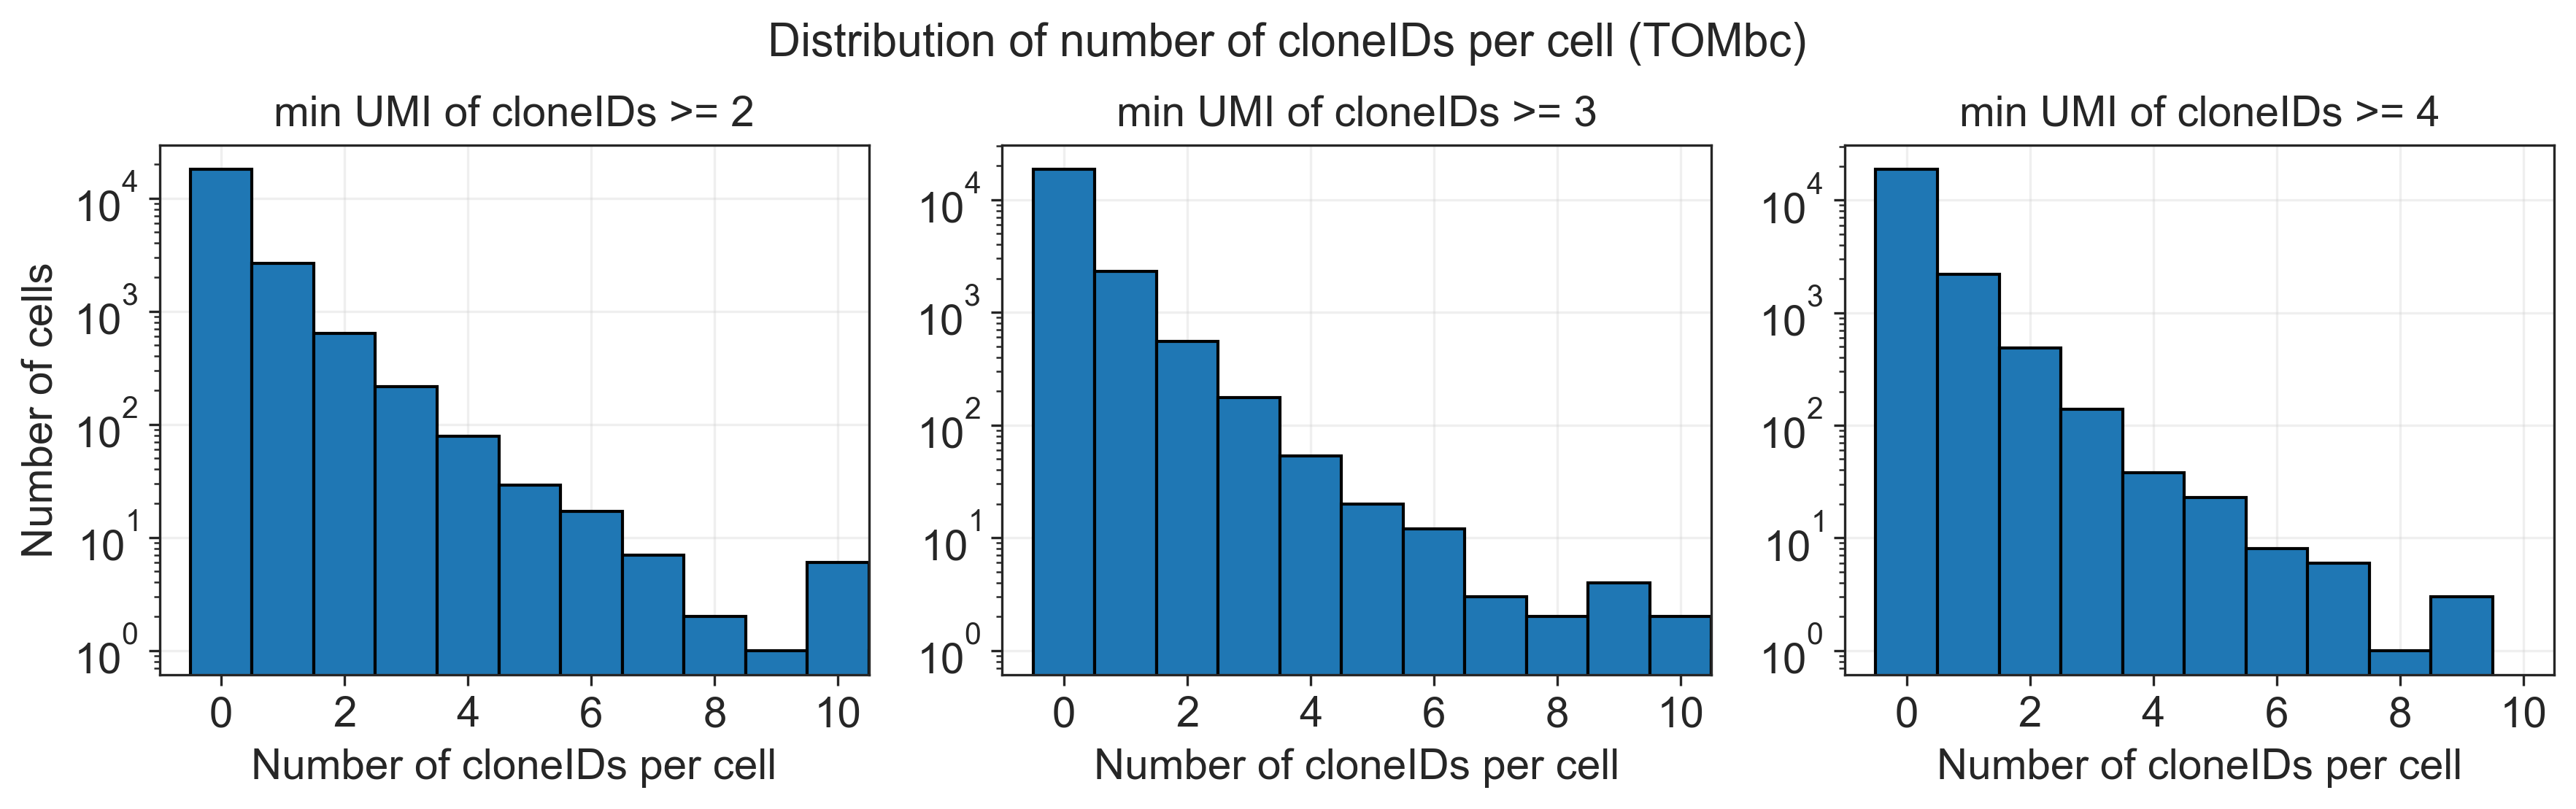

In [50]:
if len(adatas_FP) == 2:
    adatas_FP_clear = resolve_confusion(adatas_FP)
    for FP in description["FPs"]:
        fig = draw_cloneID_QC(adatas_FP_clear[FP], FP)
else:
    fig = draw_cloneID_QC(adatas_FP[description["FPs"][0]], description["FPs"][0])